### **Semantic Segmentation w/ U-Net & U-Net++**  
#### **(1) KITTI 데이터 셋**  
#### **(2) U-Net 모델 구성**  
#### **(3) U-Net++ 모델 구성**  
#### **(4) 정성적/정량적 평가**

In [1]:
#필요한 라이브러리를 로드합니다. 
import os
import PIL
import math
import skimage
import albumentations
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow import keras
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

print(tf.__version__)
print(np.__version__)
print(PIL.__version__)
print(skimage.__version__)
print(albumentations.__version__)

2.9.0
1.22.3
9.4.0
0.19.3
1.3.1


In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

---

### **(1) KITTI 데이터 셋**

[데이터 셋]  
https://www.cvlibs.net/datasets/kitti/eval_semantics.php  
[데이터 info]  
https://github.com/mcordts/cityscapesScripts/blob/master/cityscapesscripts/helpers/labels.py  
[구현 참고 링크]  
Keras Sequence에 기반한 Dataloader  
https://hwiyong.tistory.com/241  
Albumentation을 적용한 Keras sequence  
https://medium.com/the-artificial-impostor/custom-image-augmentation-with-keras-70595b01aeac 

**도로의 Label(  'road'                 ,  7 ,        0 , 'flat'            , 1       , False        , False        , (128, 64,128) ),**


**[데이터 로더(data loader) 만들기]**


- input : (224, 224)  
- output : (224, 244)

In [3]:
# data augmentation
def build_augmentation(is_train=True):
  if is_train:    # 훈련용 데이터일 경우
    return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
  return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행
                Resize(
                    width=224,
                    height=224
                    )
                ])

In [4]:
# tf.keras.utils.Sequence 상속
# Sequence를 커스텀해서 사용
class KittiGenerator(tf.keras.utils.Sequence):

    def __init__(self, dir_path, batch_size=8, img_size=(224, 224, 3), 
                 output_size=(224, 224), is_train=True, augmentation=None):
        self.dir_path = dir_path 
        self.batch_size = batch_size
        self.is_train = is_train
        self.augmentation = augmentation    # 적용할 augmentation 함수를 인자로 받음
        self.img_size = img_size            # preprocess에 사용할 input image size
        self.output_size = output_size      # ground_truth를 만들기 위한 size

        # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인
        self.data = self.load_dataset()

    def load_dataset(self):
    # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드
    # test set을 분리해서 load
        input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
        label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
        input_images.sort()
        label_images.sort()
        assert len(input_images) == len(label_images)
        data = [ _ for _ in zip(input_images, label_images)]

        if self.is_train:
            return data[:-30]
        return data[-30:]
    
    def __len__(self):
        # Generator의 length
        # 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환
        return math.ceil(len(self.data) / self.batch_size)

    def __getitem__(self, index):
        # input, output 만듦
        # input : resize및 augmentation이 적용된 input image
        # output : semantic label
        batch_data = self.data[
                            index*self.batch_size:
                            (index + 1)*self.batch_size
                            ]
        inputs = np.zeros([self.batch_size, *self.img_size])
        outputs = np.zeros([self.batch_size, *self.output_size])
            
        for i, data in enumerate(batch_data):
            input_img_path, output_path = data
            _input = imread(input_img_path)
            _output = imread(output_path)
            _output = (_output==7).astype(np.uint8)*1
            data = {"image": _input,"mask": _output,}
            augmented = self.augmentation(**data)
            inputs[i] = augmented["image"]/255
            outputs[i] = augmented["mask"]
            return inputs, outputs

    def on_epoch_end(self):
        # 한 epoch가 끝나면 실행되는 함수
        # 학습중인 경우에 순서를 random shuffle하도록 적용
        self.indexes = np.arange(len(self.data))
        if self.is_train == True :
            np.random.shuffle(self.indexes)
            return self.indexes

In [5]:
dir_path = '/Users/yena/Desktop/python_study/AIFFEL/GOINGDEEPER/semantic_segmentation/data/training'

augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

---


### **(2) U-Net 모델 구성**  

[논문]  
https://arxiv.org/pdf/1505.04597.pdf  
[논문 리뷰]  
https://medium.com/@msmapark2u-net-논문-리뷰-u-net-convolutional-networks-for-biomedical-image-segmentation-456d6901b28a  
https://youtu.be/evPZI9B2LvQ  


![]()
<img src="https://imgur.com/5hFXcYl.png" width="500px" height="300px" title="px(픽셀) 크기 설정" alt="Markdown Image"></img><br/>   

In [6]:
def conv_2_pool(input_layer, num):
    conv = keras.layers.Conv2D(num, 3, activation='relu', padding='same',kernel_initializer='he_normal')(input_layer)
    conv = keras.layers.Conv2D(num, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv)
    pool = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv)
    return conv, pool

def conv_2(input_layer, num):
    conv = keras.layers.Conv2D(num, 3, activation='relu', padding='same',kernel_initializer='he_normal')(input_layer)
    conv = keras.layers.Conv2D(num, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv)
    return conv

In [7]:
def u_net(input_shape=(224, 224, 3)):
    input_layers = keras.layers.Input(input_shape)
    contracting_nums = [64, 128, 256, 512, 1024]
    expanding_nums = [512, 256, 128, 64]

    #Contracting Path
    conv1, pool1 = conv_2_pool(input_layers, contracting_nums[0])
    conv2, pool2 = conv_2_pool(pool1, contracting_nums[1])
    conv3, pool3 = conv_2_pool(pool2, contracting_nums[2])
    conv4, pool4 = conv_2_pool(pool3, contracting_nums[3])
    conv5 = conv_2(pool4, contracting_nums[4])
    
    #Expanding Path
    up6 = keras.layers.Conv2DTranspose(512, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv5)
    merge6 = keras.layers.concatenate([conv4,up6], axis = 3)
    conv6 = conv_2(merge6, expanding_nums[0])
    
    up7 = keras.layers.Conv2DTranspose(256, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv6)
    merge7 = keras.layers.concatenate([conv3,up7], axis = 3)
    conv7 = conv_2(merge7, expanding_nums[1])

    up8 = keras.layers.Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv7)
    merge8 = keras.layers.concatenate([conv2,up8], axis = 3)
    conv8 = conv_2(merge8, expanding_nums[2])

    up9 = keras.layers.Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv8)
    merge9 = keras.layers.concatenate([conv1,up9], axis = 3)
    conv9 = conv_2(merge9, expanding_nums[3])

    # conv9 = keras.layers.Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)     
    conv10 = keras.layers.Conv2D(1, 1, activation='sigmoid')(conv9)

    model = keras.models.Model(inputs = input_layers, outputs = conv10)
    return model

In [ ]:
model_path = '/Users/yena/Desktop/python_study/AIFFEL/GOINGDEEPER/seg_model_unet.h5'

model = u_net()
model.compile(optimizer = keras.optimizers.Adam(1e-4), loss = 'binary_crossentropy')

history = model.fit(
        train_generator,
        validation_data=test_generator,
        steps_per_epoch=len(train_generator),
        epochs=100,
        verbose=1,
    )

# 모델 저장
model.save(model_path)  

---

### **(3) U-Net++ 모델 구성**  

[논문]  
https://arxiv.org/pdf/1807.10165.pdf


![]()
<img src="https://imgur.com/j2BKsod.png" width="600px" height="400px" title="px(픽셀) 크기 설정" alt="Markdown Image"></img><br/>    


![]()
<img src="https://imgur.com/jBrtyOV.png" width="500px" height="300px" title="px(픽셀) 크기 설정" alt="Markdown Image"></img><br/> 


![]()
<img src="https://imgur.com/wjs6Rwx.png" width="500px" height="100px" title="px(픽셀) 크기 설정" alt="Markdown Image"></img><br/> 

**[Loss]**   
a combination of binary cross-entropy and dice coefficient as the loss function to each of the above four semantic levels  
https://github.com/MrGiovanni/UNetPlusPlus/blob/master/keras/helper_functions.py


![]()
<img src="https://imgur.com/mFKgB3c.png" width="500px" height="150px" title="px(픽셀) 크기 설정" alt="Markdown Image"></img><br/>

In [9]:
# Custom loss function
def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = keras.backend.flatten(y_true)
    y_pred_f = keras.backend.flatten(y_pred)
    intersection = keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (keras.backend.sum(y_true_f) + keras.backend.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1. - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    return 0.5 * keras.losses.binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)

In [10]:
# backbone 없이
def u_net_plus_plus(input_shape=(224, 224, 3)):

    num_conv = [32, 64, 128, 256, 512]
    input_layer = keras.Input(shape=input_shape)
    conv0_0, pool0_0 = conv_2_pool(input_layer, 32)
    conv1_0, pool1_0 = conv_2_pool(pool0_0, 64)
    conv2_0, pool2_0 = conv_2_pool(pool1_0, 128)
    conv3_0, pool3_0 = conv_2_pool(pool2_0, 128)
    conv4_0 = conv_2(pool3_0, 128)
    
    # 규칙
    # up = keras.layers.Conv2DTranspose(num_conv, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv(i+1)_(j-1))
    # merge = keras.layers.concatenate([conv(i)_(j-1),up], axis = 3)
    # conv(i)_(j) = conv_2(merge, num_conv)

    # 3 (1번)
    up3_1 = keras.layers.Conv2DTranspose(256, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv4_0) 
    merge3_1 = keras.layers.concatenate([conv3_0,up3_1], axis = 3)
    conv3_1 = conv_2(merge3_1, 256)
    
    # 2 (2번)
    up2_1 = keras.layers.Conv2DTranspose(128, 2, activation='relu', strides=(2, 2), kernel_initializer='he_normal')(conv3_0)
    merge2_1 = keras.layers.concatenate([conv2_0, up2_1], axis = 3)
    conv2_1 = conv_2(merge2_1, 128)
    
    up2_2 = keras.layers.Conv2DTranspose(128, 2, activation='relu', strides=(2, 2), kernel_initializer='he_normal')(conv3_1)
    merge2_2 = keras.layers.concatenate([conv2_0, conv2_1, up2_2], axis = 3)
    conv2_2 = conv_2(merge2_2, 128)
    
    # 1 (3번)
    up1_1 = keras.layers.Conv2DTranspose(64, 2, activation='relu', strides=(2, 2), kernel_initializer='he_normal')(conv2_0)
    merge1_1 = keras.layers.concatenate([conv1_0, up1_1], axis = 3)
    conv1_1, pool1_1 = conv_2_pool(merge1_1, 64)
    
    up1_2 = keras.layers.Conv2DTranspose(64, 2, activation='relu', strides=(2, 2), kernel_initializer='he_normal')(conv2_1)
    merge1_2 = keras.layers.concatenate([conv1_0, conv1_1, up1_2], axis = 3)
    conv1_2, pool1_2 = conv_2_pool(merge1_2, 64)
    
    up1_3 = keras.layers.Conv2DTranspose(64, 2, activation='relu', strides=(2, 2), kernel_initializer='he_normal')(conv2_2)
    merge1_3 = keras.layers.concatenate([conv1_0, conv1_1, conv1_2, up1_3], axis = 3)
    conv1_3, pool1_3 = conv_2_pool(merge1_3, 64)
    
    # 0 (4번)
    up0_1 = keras.layers.Conv2DTranspose(32, 2, activation='relu', strides=(2, 2), kernel_initializer='he_normal')(conv1_0) 
    merge0_1 = keras.layers.concatenate([conv0_0, up0_1], axis = 3)
    conv0_1 = conv_2(merge0_1, 32)
    
    up0_2 = keras.layers.Conv2DTranspose(32, 2, activation='relu', strides=(2, 2), kernel_initializer='he_normal')(conv1_1) # (56, 56, 32) << (pool1_1)
    merge0_2 = keras.layers.concatenate([conv0_0, conv0_1, up0_2], axis=3)
    conv0_2 = conv_2(merge0_2, 32)
    
    up0_3 = keras.layers.Conv2DTranspose(32, 2, activation='relu', strides=(2, 2), kernel_initializer='he_normal')(conv1_2) # (56, 56, 32) << (pool1_2)
    merge0_3 = keras.layers.concatenate([conv0_0, conv0_1, conv0_2, up0_3], axis=3)
    conv0_3 = conv_2(merge0_3, 32)
    
    up0_4 = keras.layers.Conv2DTranspose(32, 2, activation='relu', strides=(2, 2), kernel_initializer='he_normal')(conv1_3) # (56, 56, 32) << (pool1_3)
    merge0_4 = keras.layers.concatenate([conv0_0, conv0_1, conv0_2, conv0_3, up0_4], axis=3)
    conv0_4 = conv_2(merge0_4, 32)
    
    # output 
    output1 = keras.layers.Conv2D(1, 1, padding = "same", activation = "sigmoid")(conv0_1)
    output2 = keras.layers.Conv2D(1, 1, padding = "same", activation = "sigmoid")(conv0_2)
    output3 = keras.layers.Conv2D(1, 1, padding = "same", activation = "sigmoid")(conv0_3)
    output4 = keras.layers.Conv2D(1, 1, padding = "same", activation = "sigmoid")(conv0_4)
    output = (output1 + output2 + output3 + output4) / 4
    
    model = keras.models.Model(inputs = input_layer, outputs=output)
    return model   

In [ ]:
plus_model_path = '/Users/yena/Desktop/python_study/AIFFEL/GOINGDEEPER/seg_model_unet_plus_plus.h5'

plus_model = u_net_plus_plus()
plus_model.compile(optimizer = keras.optimizers.Adam(3e-4), loss = bce_dice_loss)
plus_history = plus_model.fit(
                            train_generator,
                            validation_data=test_generator,
                            steps_per_epoch=len(train_generator),
                            epochs=100,
                            verbose=1,
                        )

# 모델 저장
plus_model.save(plus_model_path)  

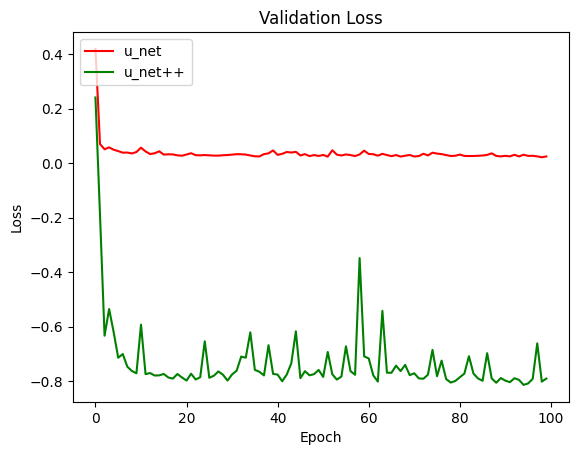

In [12]:
plt.plot(history.history['val_loss'], 'r')
plt.plot(plus_history.history['val_loss'], 'g')
plt.title('Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['u_net', 'u_net++'], loc='upper left')

plt.show()

---

### **(4) 정성적/정량적 평가**

In [13]:
# # model 불러오기
# model_path = '/Users/yena/Desktop/python_study/AIFFEL/GOINGDEEPER/seg_model_unet.h5'
# plus_model_path = '/Users/yena/Desktop/python_study/AIFFEL/GOINGDEEPER/seg_model_unet_plus_plus.h5'
 
# model = tf.keras.models.load_model(model_path)
# plus_model = tf.keras.models.load_model(plus_model_path)

In [20]:
# IoU 계산 (정량적 평가)
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    # print('IoU : %f' % iou_score )    # 평균 구할 때 주석 처리하고 진행함
    return iou_score

In [15]:
# 이미지 확인 (정성적 평가)
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  # threshold : 0.5
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5) # 정성적 결과
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

**[U-Net Model]**

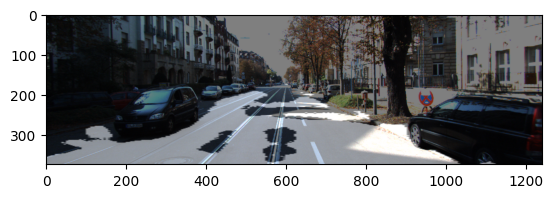

IoU : 0.737271


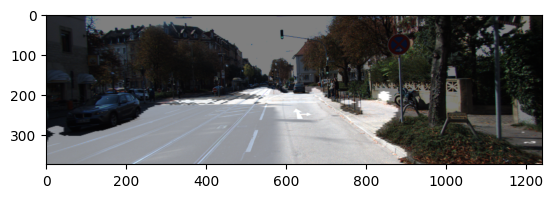

IoU : 0.850335


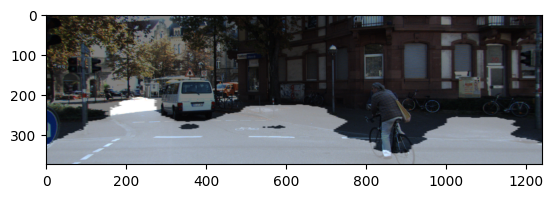

IoU : 0.721501


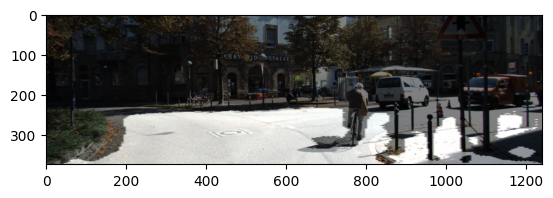

IoU : 0.642985


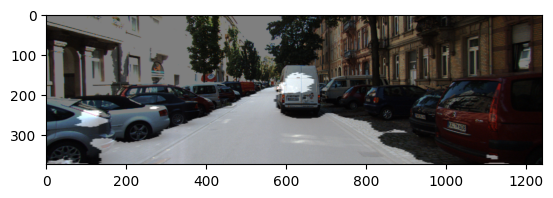

IoU : 0.640069


In [16]:
for i in range(5):
    output, prediction, target = get_output(
         model, 
         test_preproc,
         image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
         output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
         label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
        )
    plt.imshow(output)
    plt.show()
    calculate_iou_score(target, prediction)

**[U-Net++ Model]**

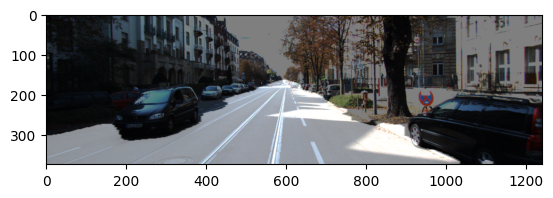

IoU : 0.907669


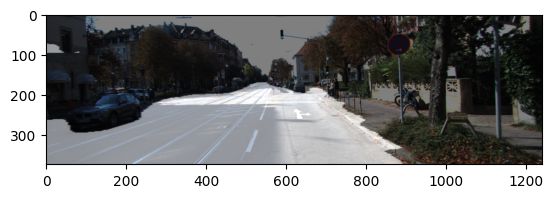

IoU : 0.909170


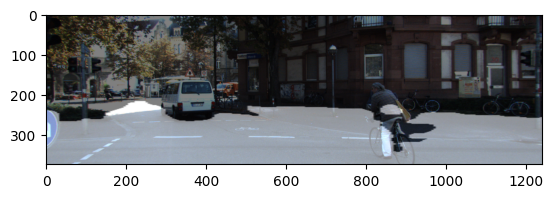

IoU : 0.630446


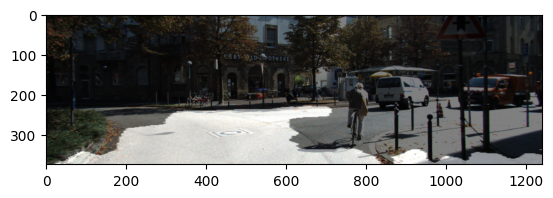

IoU : 0.561348


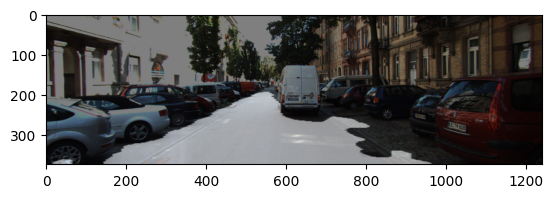

IoU : 0.743155


In [17]:
for i in range(5):
    output, prediction, target = get_output(
         plus_model, 
         test_preproc,
         image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
         output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
         label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
        )
    plt.imshow(output)
    plt.show()
    calculate_iou_score(target, prediction)

In [21]:
# 평균 Iou 비교
unet_iou = []
unet_pp_iou = []

for i in range(200):
    output, prediction, target = get_output(
         model, 
         test_preproc,
         image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
         output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
         label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
        )
    unet_iou.append(calculate_iou_score(target, prediction))
    
    pp_output, pp_prediction, pp_target = get_output(
         plus_model, 
         test_preproc,
         image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
         output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
         label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
        )
    unet_pp_iou.append(calculate_iou_score(pp_target, pp_prediction))
    

unet = sum(unet_iou)/len(unet_iou)
unet_pp = sum(unet_pp_iou)/len(unet_pp_iou)

print('U-Net 평균 IOU : ', round(unet, 4))
print('U-Net++ 평균 IOU : ', round(unet_pp, 4))


U-Net 평균 IOU :  0.7406
U-Net++ 평균 IOU :  0.754


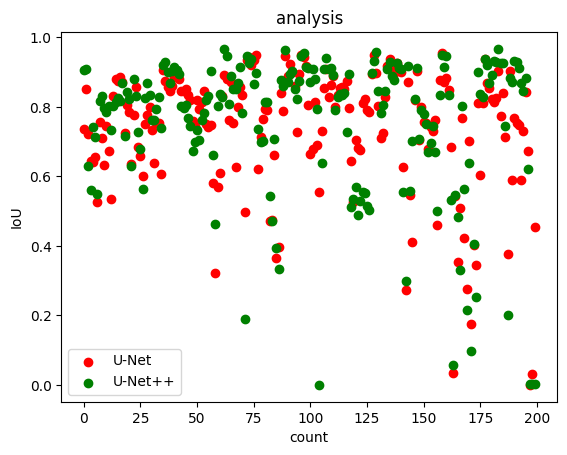

In [23]:
plt.scatter(range(len(unet_iou)), unet_iou, c="r", label="U-Net")
plt.scatter(range(len(unet_pp_iou)), unet_pp_iou, c="g", label="U-Net++")
plt.title("analysis")
plt.legend()
plt.ylabel("IoU")
plt.xlabel("count")
plt.show()

---

### **[고찰]**

<U>예상 결과</U>   
   
- U-Net++의 성능(평균 IoU)이 높게 나타날 것이다. 
  
<U>실험 결과</U>  
  
- U-Net++의 평균 IoU가 .7540로 U-Net의 평균 IoU인 .7406보다 높게 나왔다.  
  

<U>🤔</U>  


![]()
<img src="https://imgur.com/jsx1iP8.png" width="500px" height="200px" title="px(픽셀) 크기 설정" alt="Markdown Image"></img><br/> 


- Backbone 없이 구조만 구현했기 때문에 <U>월등한</U> 차이를 볼 수는 없었다
  
    - resnet101을 backbone으로 하여 논문 구현을 시도했으나 실패하고 구조만 구현했다.
    - conv0_0, conv1_0, conv2_0, conv3_0, conv4_0로 가져온 layer와 구현한 layer를 확인하는 과정이 필요하다.  
    - model.summary() 뿐 아니라 keras.utils.plot_model(model, show_shapes=True)을 활용하는 것이 좋다.  
